In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from scipy_mod import de_generator
from scipy.stats import qmc, shapiro
import torch_rbf as rbf

In [2]:
dataset = 'protein'
task = 1 # only relevant for Indoorloc (1) and telemonitoring (2), ignored for other datasets

from_raw = False
if from_raw:
    data = pd.read_csv(f"datasets\\{dataset}\\{dataset}.csv")
    X = data.iloc[:, :-1].to_numpy()
    y = data.iloc[:,-1].to_numpy()
    np.save(f"datasets\\{dataset}\\X.npy", X)
    np.save(f"datasets\\{dataset}\\y.npy", y)

else:
    X = np.load(os.path.join("datasets", dataset, "X.npy"))
    if dataset in ['Indoorloc', 'telemonitoring']:
        y = np.load(os.path.join("datasets", dataset, f"y{task}.npy"))
    else:
        y = np.load(os.path.join("datasets", dataset, f"y.npy"))

print(X.shape, y.shape)

(3148, 20) (3148,)


R2 score: 0.4007613430825353
RMSE: 0.24572783465951598


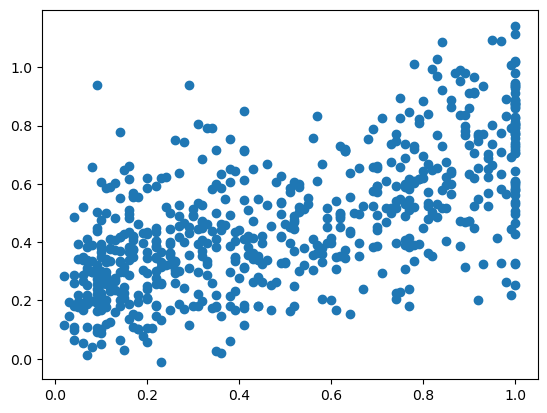

In [3]:
# simple sklearn model

# standardize y to mean 0, std 1
#y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))
y_scaled = y.reshape(-1,1)
#X_scaled = preprocessing.StandardScaler().fit_transform(X)
X_scaled = X

# train test split
if dataset == 'protein':
    train_size = 2500
else:
    train_size = 5000
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled.reshape(-1), train_size=train_size, random_state=0)

run_SVM = True
if run_SVM:
    svr_model = SVR() #SVR() 
    svr_model.fit(X_train, y_train)

    y_pred = svr_model.predict(X_test)
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    plt.scatter(y_test, y_pred)

In [4]:
import math
def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)

In [5]:
# Train teacher model
basis_func = rbf.gaussian #gaussian

class Regressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Regressor, self).__init__()
        self.hidden = rbf.RBF(input_size, hidden_size, basis_func)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        #x = torch.clip(x, 0, 1)
        return x

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = nn.Tanh()(x)
        x = self.output(x)
        return x

In [6]:
def train_epoch(model, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = 0.0
    for x, y in dataloader:
        y_pred = model(x.float().to(device))
        loss = torch.nn.MSELoss()(y_pred.reshape(-1), y.float().to(device))
        #loss = LogCoshLoss()(y_pred.reshape(-1), y.float().to(device))
        train_loss += loss.cpu().item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss / len(dataloader)

def valid_epoch(model, device, dataloader):
    # Set train mode for both the encoder and the decoder
    model.eval()
    valid_loss = 0.0
    for x, y in dataloader:
        y_pred = model(x.float().to(device))
        loss = torch.nn.MSELoss()(y_pred.reshape(-1), y.float().to(device))
        valid_loss += loss.cpu().item()
    return valid_loss / len(dataloader)

In [7]:
def train_model(model, train_loader, valid_loader, lr, device, save_path, epochs=100):
    model = model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-6)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)

    bar = tqdm(range(epochs))
    train_losses = []
    valid_losses = []
    min_val_loss = np.inf
    patience = 150
    patience_step = 0
    for epoch in bar:
        train_loss = train_epoch(model, device, train_loader, optimizer)
        valid_loss = valid_epoch(model, device, valid_loader)
        bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}  valid RMSE {np.sqrt(valid_loss):.6f}")
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < min_val_loss:
            min_val_loss = valid_loss
            torch.save(model.state_dict(), save_path)
        else:
            scheduler.step(valid_loss)
            patience_step += 1
        if patience_step > patience:
            break
    return train_losses, valid_losses

In [8]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=0.1, random_state=42)

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=False)

In [9]:
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)

In [10]:
# Train generator

def generator_loss(x: torch.Tensor, teacher_model, student_model):
    teacher_model.eval().to(device)
    student_model.eval().to(device)
    teacher_label = teacher_model(x.float().to(device))
    student_pred = student_model(x.float().to(device))
    return -(teacher_label - student_pred)**2, student_pred

def teacher_pred(x: np.array, teacher_model, student_model):
    x = torch.from_numpy(x)
    teacher_model.eval().to(device)
    student_model.eval().to(device)
    
    with torch.no_grad():
        teacher_label = teacher_model(x.float().to(device))
        student_pred = student_model(x.float().to(device))
    teacher_label = teacher_label.cpu().detach().numpy()
    student_pred = student_pred.cpu().detach().numpy()
    return -(teacher_label - student_pred)**2

In [11]:
class FunctionWrapper(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, m, d):
        super().__init__()
        #weights = torch.randn(m, d).to(device)
        sampler = qmc.LatinHypercube(d)
        weights = sampler.random(n=m)
        weights = torch.from_numpy(weights).to(device)
        self.weights = nn.Parameter(weights.float())
        
    def forward(self, teacher_model, student_model):
        teacher_model.eval().to(device)
        student_model.eval().to(device)
        teacher_label = teacher_model(self.weights.to(device))
        student_pred = student_model(self.weights.to(device))
        return -(teacher_label - student_pred)**2, student_pred

  0%|                                                                                              | 0/1000 [00:00<?, ?it/s]
 EPOCH 1/1000 	 train loss 15.170383  valid RMSE 0.30569:   0%|                                   | 0/1000 [00:00<?, ?it/s]
 EPOCH 1/1000 	 train loss 15.170383  valid RMSE 0.30569:   0%|                           | 1/1000 [00:00<09:43,  1.71it/s]
 EPOCH 2/1000 	 train loss 5.493279  valid RMSE 0.30292:   0%|                            | 1/1000 [00:01<09:43,  1.71it/s]
 EPOCH 2/1000 	 train loss 5.493279  valid RMSE 0.30292:   0%|                            | 2/1000 [00:01<09:54,  1.68it/s]
 EPOCH 3/1000 	 train loss 5.228237  valid RMSE 0.30235:   0%|                            | 2/1000 [00:01<09:54,  1.68it/s]
 EPOCH 3/1000 	 train loss 5.228237  valid RMSE 0.30235:   0%|                            | 3/1000 [00:01<09:48,  1.69it/s]
 EPOCH 4/1000 	 train loss 5.271538  valid RMSE 0.30525:   0%|                            | 3/1000 [00:02<09:48,  1.69it/s]
 EPOCH 

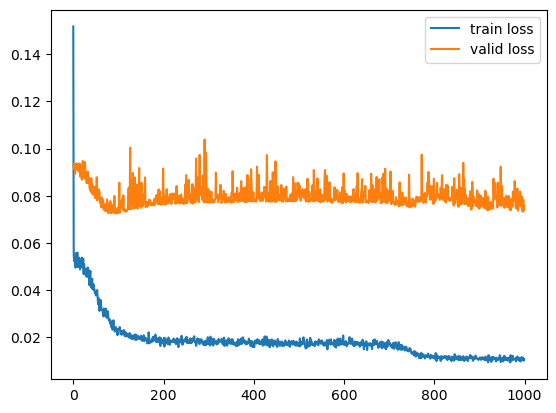

In [23]:
# Train student with baseline method 
retrain = True
continue_training = False
#model.eval()
epochs = 1000
ns = 100
m = 100
bar = tqdm(range(epochs))
bounds = np.array(list(zip(np.min(X_test, axis=0), np.max(X_test, axis=0))))
student_size = 100
student_model = Regressor(input_size=X.shape[1], hidden_size=student_size)
student_save_path = f"baseline_models\\protein_baseline_svm.pt"
if continue_training:
    student_model.load_state_dict(torch.load(student_save_path))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.001
optimizer = torch.optim.RMSprop(student_model.parameters(), lr=lr, weight_decay=1e-6)

train_losses = []
valid_losses = []
min_val_loss = np.inf

sampler = qmc.LatinHypercube(X_test.shape[1])
bounds = np.array(list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)+0.01)))

if retrain:
    for epoch in bar:
        train_loss = 0.0
        for i in range(ns):
            # generate synthetic data
            xp = np.clip(np.random.normal(loc=means, scale=stds, size=(10, len(bounds))), 0, 1)
            #xp = sampler.random(n=m)
            xp = xp/np.sum(xp, axis=1).reshape(-1,1)
            #xp = sampler.random(n=m)
            #xp = qmc.scale(xp, bounds[:,0], bounds[:,1])

            '''
            samples = torch.from_numpy(xp).float()
            with torch.no_grad():
                model.eval().to(device)
                teacher_label = model(samples.to(device))
            '''
            teacher_label = svr_model.predict(xp)
            teacher_label = torch.from_numpy(teacher_label).float().to(device)
            xp = torch.from_numpy(xp).float()
            
            # train student model
            student_model.train().to(device)
            student_pred = student_model(xp.to(device))
            loss = torch.nn.MSELoss()(student_pred.reshape(-1), teacher_label.reshape(-1))
            train_loss += loss.cpu().item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        valid_loss = valid_epoch(student_model, device, valid_loader)
        train_losses.append(train_loss/ns)
        valid_losses.append(valid_loss)
        bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}  valid RMSE {np.sqrt(valid_loss):.5f}")
        if valid_loss < min_val_loss:
            torch.save(student_model.state_dict(), student_save_path)
            min_val_loss = valid_loss

    plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
    plt.plot(np.arange(len(valid_losses)), valid_losses, label='valid loss')
    plt.legend()

In [24]:
student_size = 100
student_model = Regressor(input_size=X.shape[1], hidden_size=student_size)
student_save_path = f"baseline_models\\protein_baseline_svm.pt"
#baseline_model_path = f"student_models\\S_{student_size}_{dataset}_baseline.pt"
student_model.load_state_dict(torch.load(student_save_path))

<All keys matched successfully>

R2 score: 0.17701563919858843
RMSE: 0.2886732721634787


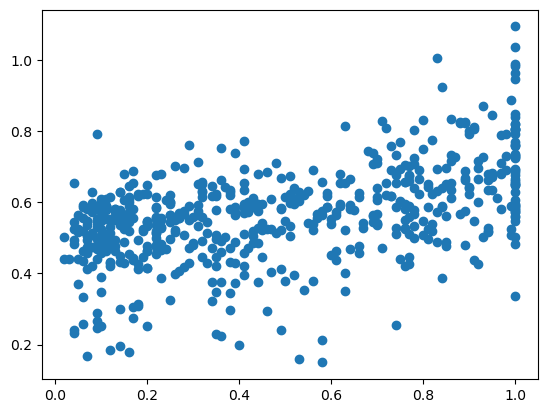

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
student_model.eval().to(device)
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        pred = student_model(x.float().to(device))
        pred = pred.cpu().detach().item()
        y_pred.append(pred)
y_pred = np.array(y_pred).reshape(-1)

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
plt.scatter(y_test, y_pred)

In [15]:
def student_loss(x: np.array, teacher_model, student_model, rand=0.5):
    x = x/np.sum(x)
    teacher_label = teacher_model.predict(x.reshape(-1, dim_x))
    
    x = torch.from_numpy(x).view(-1, dim_x)
    student_model.eval().to(device)
    
    with torch.no_grad():
        student_pred = student_model(x.float().to(device))
    student_pred = student_pred.cpu().detach().numpy()
    
    #return (teacher_label - rand)**2
    return -0.05*(teacher_label - student_pred)**2 + (teacher_label - rand)**2

  0%|                                                                                              | 0/1000 [00:00<?, ?it/s]
 EPOCH 1/1000 	 train loss 25.291260  valid RMSE 0.30086:   0%|                                   | 0/1000 [00:21<?, ?it/s]
 EPOCH 1/1000 	 train loss 25.291260  valid RMSE 0.30086:   0%|                         | 1/1000 [00:21<5:58:03, 21.50s/it]
 EPOCH 2/1000 	 train loss 6.592497  valid RMSE 0.30113:   0%|                          | 1/1000 [00:43<5:58:03, 21.50s/it]
 EPOCH 2/1000 	 train loss 6.592497  valid RMSE 0.30113:   0%|                          | 2/1000 [00:43<6:06:31, 22.04s/it]
 EPOCH 3/1000 	 train loss 6.122748  valid RMSE 0.30027:   0%|                          | 2/1000 [01:06<6:06:31, 22.04s/it]
 EPOCH 3/1000 	 train loss 6.122748  valid RMSE 0.30027:   0%|                          | 3/1000 [01:06<6:11:10, 22.34s/it]
 EPOCH 4/1000 	 train loss 6.602611  valid RMSE 0.30032:   0%|                          | 3/1000 [01:28<6:11:10, 22.34s/it]
 EPOCH 

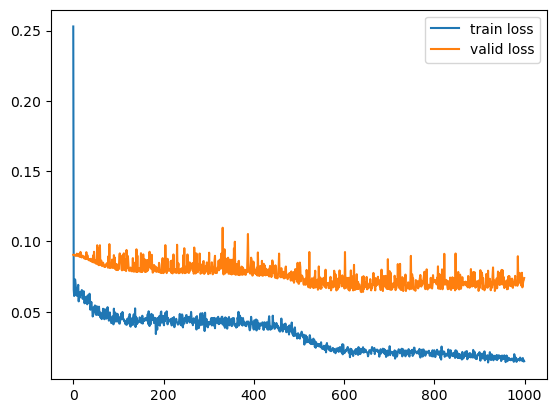

In [26]:
# Train student with new method

dim_x = X_test.shape[1]
epochs = 1000
ns = 100
m = 100
bar = tqdm(range(epochs))
bounds = np.array(list(zip(np.min(X_test, axis=0), np.max(X_test, axis=0))))
student_size = 100
student_model = Regressor(input_size=X.shape[1], hidden_size=student_size).to(device)
student_save_path = os.path.join("student_models", "protein_de.pt")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.001
optimizer = torch.optim.RMSprop(student_model.parameters(), lr=lr, weight_decay=1e-6)

train_losses = []
valid_losses = []
min_val_loss = np.inf

bounds = np.array(list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)+0.01)))

for epoch in bar:
    train_loss = 0.0
    for i in range(ns):
        # generate synthetic data
        xp = np.clip(np.random.normal(loc=means, scale=stds, size=(5, len(bounds))), 0, 1)
        xp = xp/np.sum(xp, axis=1).reshape(-1,1)
        rand = np.random.uniform()
        _, xpd, _ = de_generator(student_loss, bounds, args=(svr_model, student_model, rand), init=xp, strategy='best2bin', maxiter=25, polish=False)

        xpd = xpd/np.sum(xp, axis=1).reshape(-1,1)
        xp = np.vstack((xp, xpd))

        teacher_label = svr_model.predict(xp)
        teacher_label = torch.from_numpy(teacher_label).float().to(device)
        xp = torch.from_numpy(xp).float()

        # train student model
        student_model.train().to(device)
        student_pred = student_model(xp.to(device))
        loss = torch.nn.MSELoss()(student_pred.reshape(-1), teacher_label.reshape(-1))
        train_loss += loss.cpu().item()

        #print(rand, torch.mean(teacher_label), torch.mean(student_pred))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    valid_loss = valid_epoch(student_model, device, valid_loader)
    train_losses.append(train_loss/ns)
    valid_losses.append(valid_loss)
    bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}  valid RMSE {np.sqrt(valid_loss):.5f}")
    if valid_loss < min_val_loss:
        torch.save(student_model.state_dict(), student_save_path)
        min_val_loss = valid_loss

plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
plt.plot(np.arange(len(valid_losses)), valid_losses, label='valid loss')
plt.legend()

R2 score: 0.2592658801006724
RMSE: 0.2738684215373483


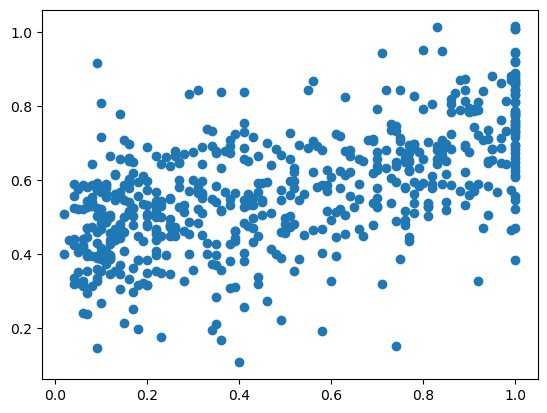

In [27]:
student = Regressor(input_size=X.shape[1], hidden_size=student_size).to(device)
student_save_path = os.path.join("student_models", "protein_de.pt")
student.load_state_dict(torch.load(student_save_path))

student.eval().to(device)
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        pred = student(x.float().to(device))
        pred = pred.cpu().detach().item()
        y_pred.append(pred)
y_pred = np.array(y_pred).reshape(-1)

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
plt.scatter(y_test, y_pred)

  0%|                                                                                              | 0/1000 [00:00<?, ?it/s]
 EPOCH 1/1000 	 train loss 16.611992  valid RMSE 0.30039:   0%|                                   | 0/1000 [00:20<?, ?it/s]
 EPOCH 1/1000 	 train loss 16.611992  valid RMSE 0.30039:   0%|                         | 1/1000 [00:20<5:39:03, 20.36s/it]
 EPOCH 2/1000 	 train loss 6.539102  valid RMSE 0.29900:   0%|                          | 1/1000 [00:41<5:39:03, 20.36s/it]
 EPOCH 2/1000 	 train loss 6.539102  valid RMSE 0.29900:   0%|                          | 2/1000 [00:41<5:46:16, 20.82s/it]
 EPOCH 3/1000 	 train loss 6.966986  valid RMSE 0.29922:   0%|                          | 2/1000 [01:02<5:46:16, 20.82s/it]
 EPOCH 3/1000 	 train loss 6.966986  valid RMSE 0.29922:   0%|                          | 3/1000 [01:02<5:49:05, 21.01s/it]
 EPOCH 4/1000 	 train loss 6.225843  valid RMSE 0.30047:   0%|                          | 3/1000 [01:24<5:49:05, 21.01s/it]
 EPOCH 

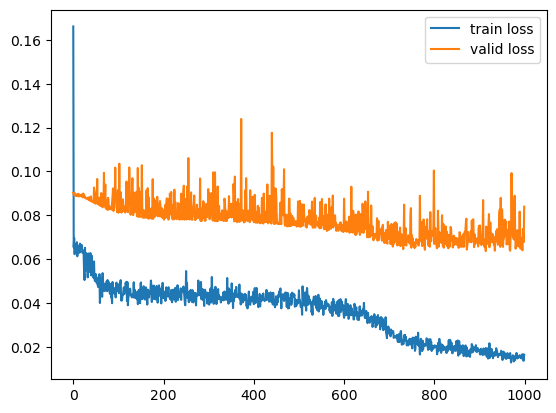

In [28]:
# Train student with new method

dim_x = X_test.shape[1]
epochs = 1000
ns = 100
m = 100
bar = tqdm(range(epochs))
bounds = np.array(list(zip(np.min(X_test, axis=0), np.max(X_test, axis=0))))
student_size = 100
student_model = Regressor(input_size=X.shape[1], hidden_size=student_size).to(device)
student_save_path = os.path.join("student_models", "protein_de.pt")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.001
optimizer = torch.optim.RMSprop(student_model.parameters(), lr=lr, weight_decay=1e-6)

train_losses = []
valid_losses = []
min_val_loss = np.inf

bounds = np.array(list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)+0.01)))

for epoch in bar:
    train_loss = 0.0
    for i in range(ns):
        # generate synthetic data
        xp = np.clip(np.random.normal(loc=means, scale=stds, size=(5, len(bounds))), 0, 1)
        xp = xp/np.sum(xp, axis=1).reshape(-1,1)
        rand = np.random.uniform()
        _, xpd, _ = de_generator(student_loss, bounds, args=(svr_model, student_model, rand), init=xp, strategy='best2bin', maxiter=25, polish=False)

        xpd = xpd/np.sum(xp, axis=1).reshape(-1,1)
        xp = np.vstack((xp, xpd))

        teacher_label = svr_model.predict(xp)
        teacher_label = torch.from_numpy(teacher_label).float().to(device)
        xp = torch.from_numpy(xp).float()

        # train student model
        student_model.train().to(device)
        student_pred = student_model(xp.to(device))
        loss = torch.nn.MSELoss()(student_pred.reshape(-1), teacher_label.reshape(-1))
        train_loss += loss.cpu().item()

        #print(rand, torch.mean(teacher_label), torch.mean(student_pred))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    valid_loss = valid_epoch(student_model, device, valid_loader)
    train_losses.append(train_loss/ns)
    valid_losses.append(valid_loss)
    bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}  valid RMSE {np.sqrt(valid_loss):.5f}")
    if valid_loss < min_val_loss:
        torch.save(student_model.state_dict(), student_save_path)
        min_val_loss = valid_loss

plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
plt.plot(np.arange(len(valid_losses)), valid_losses, label='valid loss')
plt.legend()

R2 score: 0.31109126454446534
RMSE: 0.2641141259266793


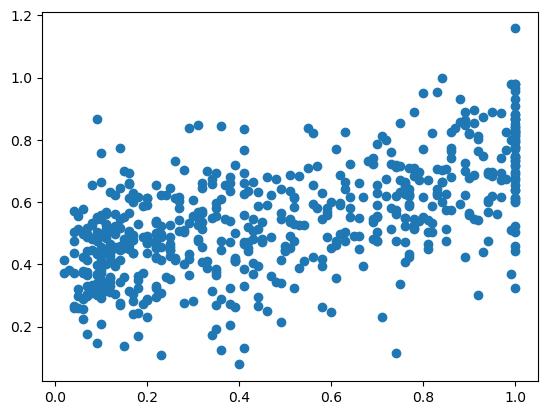

In [29]:
student = Regressor(input_size=X.shape[1], hidden_size=student_size).to(device)
student_save_path = os.path.join("student_models", "protein_de.pt")
student.load_state_dict(torch.load(student_save_path))

student.eval().to(device)
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        pred = student(x.float().to(device))
        pred = pred.cpu().detach().item()
        y_pred.append(pred)
y_pred = np.array(y_pred).reshape(-1)

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
plt.scatter(y_test, y_pred)